In [3]:
import pandas as pd
import random
import numpy as np

# Müşteri verisi oluşturmak için
def create_customer_data(num_customers=500):
    # Rasgele isimler ve soyadları
    first_names = ['Ahmet', 'Mehmet', 'Ayşe', 'Fatma', 'Emine', 'Hakan', 'Murat', 'Zeynep', 'Ali', 'Veli']
    last_names = ['Yılmaz', 'Demir', 'Çelik', 'Kaya', 'Arslan', 'Güzel', 'Bozkurt', 'Şahin', 'Öztürk', 'Yalçın']
    
    # Rasgele ürün isimleri
    product_names = ['Laptop', 'Telefon', 'Tablet', 'Kulaklık', 'Monitör', 'Klavye', 'Fare', 'Baskı Makinesi', 'Wi-Fi Router', 'Kamera']
    
    # Rastgele satış adetleri
    sales_quantities = [random.randint(1, 10) for _ in range(num_customers)]
    
    # Random olarak müşteri verisi oluştur
    customer_data = []
    for _ in range(num_customers):
        first_name = random.choice(first_names)
        last_name = random.choice(last_names)
        product_name = random.choice(product_names)
        quantity = random.choice(sales_quantities)
        total_spent = quantity * random.randint(50, 1000)  # Ürün başına fiyat
        customer_data.append({
            'Müşteri Adı': f"{first_name} {last_name}",
            'Ürün Adı': product_name,
            'Satış Adedi': quantity,
            'Toplam Harcama': total_spent
        })
    
    return pd.DataFrame(customer_data)

# 500 müşteri verisini oluştur
df = create_customer_data(500)

# CSV dosyasına kaydediyoruz
csv_filename = "customer_data_large.csv"
df.to_csv(csv_filename, index=False)

print(f"CSV dosyası oluşturuldu: {csv_filename}")


CSV dosyası oluşturuldu: customer_data_large.csv


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


     Müşteri Adı  Frequency  Monetary  Recency  Segment
0   Ahmet Arslan          7     24559       45        2
1  Ahmet Bozkurt          2      6202       45        0
2    Ahmet Demir          3      5026       45        0
3    Ahmet Güzel          4     10087       45        3
4     Ahmet Kaya          5     14941       45        3


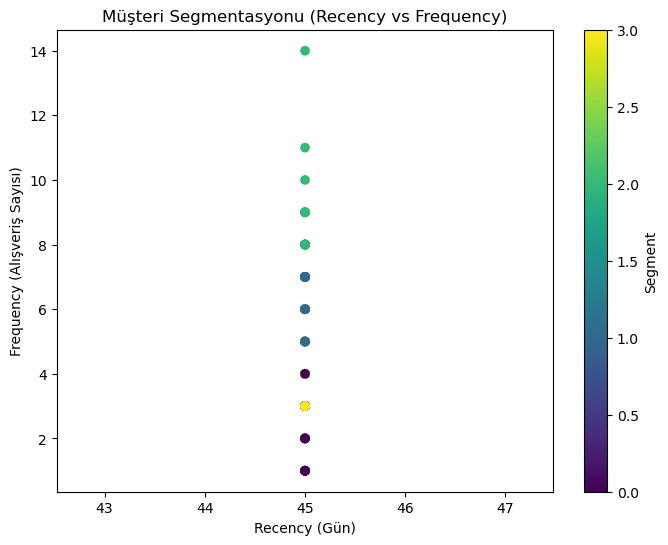

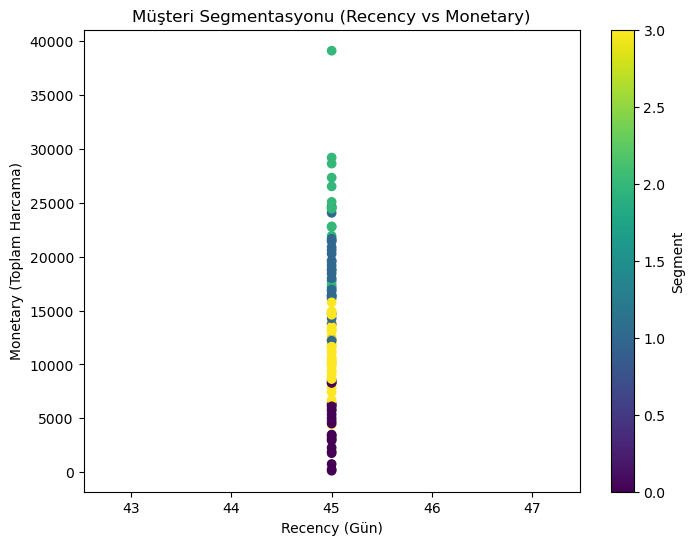

Segment
0     4278.521739
1    18171.071429
2    25725.923077
3    11126.571429
Name: Monetary, dtype: float64


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# CSV dosyasını yükleyelim
df = pd.read_csv('customer_data_large.csv')

# Veriyi inceledikten sonra, Recency, Frequency ve Monetary hesaplamalarını yapalım

# Recency: En son alışveriş yapma zamanı
df['Müşteri Adı'] = df['Müşteri Adı'].astype(str)
df['Tarih'] = pd.to_datetime('2025-02-15')  # Bugün tarihi (veri tabanında tarih olmadığından varsayılan tarih veriyoruz)
df['Alışveriş Tarihi'] = pd.to_datetime('2025-01-01')  # Verilerde gerçek alışveriş tarihi olmadığı için örnek tarih

# Recency hesaplaması (bugün ile alışveriş tarihi arasındaki fark)
df['Recency'] = (df['Tarih'] - df['Alışveriş Tarihi']).dt.days

# Frequency: Alışveriş sayısı
frequency_df = df.groupby('Müşteri Adı')['Ürün Adı'].count().reset_index()
frequency_df.columns = ['Müşteri Adı', 'Frequency']

# Monetary: Toplam harcama (satış adedi * ürün fiyatı)
# Satış adedi ve toplam harcama mevcut, ancak toplam harcama hesaplamasını yapmamız gerekiyor
df['Monetary'] = df['Satış Adedi'] * np.random.randint(50, 1000, size=len(df))

# Müşterilerin toplam harcamalarını alalım
monetary_df = df.groupby('Müşteri Adı')['Monetary'].sum().reset_index()
monetary_df.columns = ['Müşteri Adı', 'Monetary']

# RFM DataFrame'ini birleştiriyoruz
rfm_df = pd.merge(frequency_df, monetary_df, on='Müşteri Adı')
rfm_df = pd.merge(rfm_df, df[['Müşteri Adı', 'Recency']].drop_duplicates(), on='Müşteri Adı')

# Veriyi standartlaştırıyoruz
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

# K-means kümeleme algoritması ile segmentasyon yapalım
kmeans = KMeans(n_clusters=4, random_state=42)  # 4 segment (K=4) seçtik, isterseniz değiştirebilirsiniz
rfm_df['Segment'] = kmeans.fit_predict(rfm_scaled)

# Sonuçları görüntüleyelim
print(rfm_df.head())

# Grafik 1: Recency ve Frequency ile Segment Görselleştirme
plt.figure(figsize=(8, 6))
plt.scatter(rfm_df['Recency'], rfm_df['Frequency'], c=rfm_df['Segment'], cmap='viridis')
plt.xlabel('Recency (Gün)')
plt.ylabel('Frequency (Alışveriş Sayısı)')
plt.title('Müşteri Segmentasyonu (Recency vs Frequency)')
plt.colorbar(label='Segment')
plt.show()

# Grafik 2: Monetary ile Segment Görselleştirme
plt.figure(figsize=(8, 6))
plt.scatter(rfm_df['Recency'], rfm_df['Monetary'], c=rfm_df['Segment'], cmap='viridis')
plt.xlabel('Recency (Gün)')
plt.ylabel('Monetary (Toplam Harcama)')
plt.title('Müşteri Segmentasyonu (Recency vs Monetary)')
plt.colorbar(label='Segment')
plt.show()

# Müşteri segmentlerine göre toplam harcama ortalamalarını gösterelim
print(rfm_df.groupby('Segment')['Monetary'].mean())


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Segment
0    19365.700000
1     5735.956522
2    31544.250000
3    12347.473684
Name: Monetary, dtype: float64


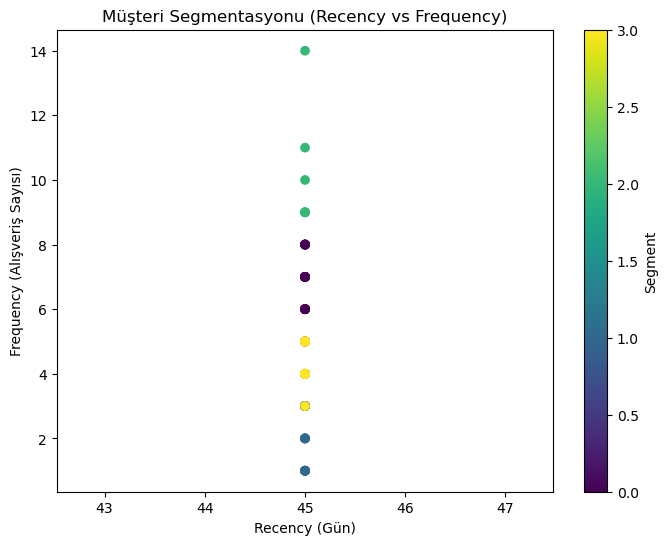

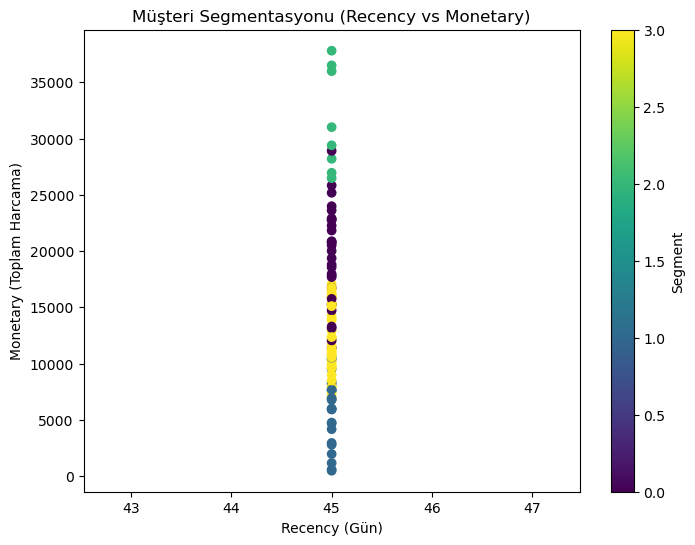

In [7]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Verilerinizi yükleyelim (önceden oluşturulmuş CSV dosyası ile)
df = pd.read_csv('customer_data_large.csv')

# Müşteri segmentasyonu hesaplamalarını yapalım (Recency, Frequency, Monetary)
df['Müşteri Adı'] = df['Müşteri Adı'].astype(str)
df['Tarih'] = pd.to_datetime('2025-02-15')  # Bugün tarihi
df['Alışveriş Tarihi'] = pd.to_datetime('2025-01-01')  # Varsayılan tarih

# Recency hesaplama
df['Recency'] = (df['Tarih'] - df['Alışveriş Tarihi']).dt.days

# Frequency hesaplama
frequency_df = df.groupby('Müşteri Adı')['Ürün Adı'].count().reset_index()
frequency_df.columns = ['Müşteri Adı', 'Frequency']

# Monetary hesaplama
df['Monetary'] = df['Satış Adedi'] * np.random.randint(50, 1000, size=len(df))
monetary_df = df.groupby('Müşteri Adı')['Monetary'].sum().reset_index()
monetary_df.columns = ['Müşteri Adı', 'Monetary']

# RFM DataFrame'ini birleştiriyoruz
rfm_df = pd.merge(frequency_df, monetary_df, on='Müşteri Adı')
rfm_df = pd.merge(rfm_df, df[['Müşteri Adı', 'Recency']].drop_duplicates(), on='Müşteri Adı')

# Veriyi standartlaştırıyoruz
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

# K-means kümeleme algoritması ile segmentasyon
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['Segment'] = kmeans.fit_predict(rfm_scaled)

# Grafik 1: Recency ve Frequency ile Segment Görselleştirme
plt.figure(figsize=(8, 6))
plt.scatter(rfm_df['Recency'], rfm_df['Frequency'], c=rfm_df['Segment'], cmap='viridis')
plt.xlabel('Recency (Gün)')
plt.ylabel('Frequency (Alışveriş Sayısı)')
plt.title('Müşteri Segmentasyonu (Recency vs Frequency)')
plt.colorbar(label='Segment')

# Dosya yolunu belirtiyoruz
output_dir = r'C:\Users\USER\Desktop\my_web_site\veri_analizi_python\musteri_segmentasyonu'
os.makedirs(output_dir, exist_ok=True)

# Grafik 1'i kaydedelim
plt.savefig(os.path.join(output_dir, 'recency_frequency_segment.png'))

# Grafik 2: Monetary ile Segment Görselleştirme
plt.figure(figsize=(8, 6))
plt.scatter(rfm_df['Recency'], rfm_df['Monetary'], c=rfm_df['Segment'], cmap='viridis')
plt.xlabel('Recency (Gün)')
plt.ylabel('Monetary (Toplam Harcama)')
plt.title('Müşteri Segmentasyonu (Recency vs Monetary)')
plt.colorbar(label='Segment')

# Grafik 2'yi kaydedelim
plt.savefig(os.path.join(output_dir, 'recency_monetary_segment.png'))

# Müşteri segmentlerine göre toplam harcama ortalamalarını gösterelim
print(rfm_df.groupby('Segment')['Monetary'].mean())
